In [1]:
# import os

# args.output_attention = True

# exp = Exp(args)

# model = exp.model

# setting = 'ETTh1_96_24_Autoformer_ETTh1_ftM_sl96_ll48_pl24_dm512_nh8_el2_dl1_df2048_fc1_ebtimeF_dtTrue_Exp_0'
# path = os.path.join(args.checkpoints,setting,'checkpoint.pth')
# model.load_state_dict(torch.load(path))

###### *Cuda GPU Setup*
This part of code checks whether a CUDA GPU is available, how many GPUs are available, what the name of the current GPU is, and what the current GPU device is. It then sets the current device to the first GPU (device 0).

In [2]:
import torch
import os
print(torch.cuda.is_available())
print(torch.cuda.device_count())
print(torch.cuda.get_device_name())
print(torch.cuda.current_device())
torch.cuda.set_device(0)

os.environ["CUDA_VISIBLE_DEVICES"] = '0' #disable CUDA by setting CUDA_VISIBLE_DEVICES to an empty string 

True
1
NVIDIA GeForce GTX 1660 Ti
0


In [3]:
import argparse
from exp.exp_main import Exp_Main #exp stands for experiments
import random
import numpy as np
from utils.tools import dotdict

fix_seed = 2021 
random.seed(fix_seed)
torch.manual_seed(fix_seed)
np.random.seed(fix_seed)

parser = argparse.ArgumentParser(description='Autoformer & Transformer family for Time Series Forecasting')

# basic config
parser.add_argument('--is_training', type=int, required=True, default=1, help='status')
parser.add_argument('--model_id', type=str, required=True, default='test', help='model id')
parser.add_argument('--model', type=str, required=True, default='Autoformer',
                    help='model name, options: [Autoformer, Informer, Transformer]')

# data loader
parser.add_argument('--data', type=str, required=True, default='ETTm1', help='dataset type')
parser.add_argument('--root_path', type=str, default='./data/ETT/', help='root path of the data file')
parser.add_argument('--data_path', type=str, default='ETTh1.csv', help='data file')
parser.add_argument('--features', type=str, default='M',
                    help='forecasting task, options:[M, S, MS]; M:multivariate predict multivariate, S:univariate predict univariate, MS:multivariate predict univariate')
parser.add_argument('--target', type=str, default='OT', help='target feature in S or MS task')
parser.add_argument('--freq', type=str, default='h',
                    help='freq for time features encoding, options:[s:secondly, t:minutely, h:hourly, d:daily, b:business days, w:weekly, m:monthly], you can also use more detailed freq like 15min or 3h')
parser.add_argument('--checkpoints', type=str, default='./checkpoints/', help='location of model checkpoints')

# forecasting task
parser.add_argument('--seq_len', type=int, default=96, help='input sequence length')
parser.add_argument('--label_len', type=int, default=48, help='start token length')
parser.add_argument('--pred_len', type=int, default=24, help='prediction sequence length')

# model define
parser.add_argument('--bucket_size', type=int, default=4, help='for Reformer')#Reformer专用属性
parser.add_argument('--n_hashes', type=int, default=4, help='for Reformer')#Reformer专用属性
parser.add_argument('--enc_in', type=int, default=7, help='encoder input size')#encoder input size
parser.add_argument('--dec_in', type=int, default=7, help='decoder input size')#decoder input size
parser.add_argument('--c_out', type=int, default=7, help='output size')#输出长度
parser.add_argument('--d_model', type=int, default=512, help='dimension of model')#dimension of model
parser.add_argument('--n_heads', type=int, default=8, help='num of heads')#num of heads 
parser.add_argument('--e_layers', type=int, default=2, help='num of encoder layers')#num of encoder layers
parser.add_argument('--d_layers', type=int, default=1, help='num of decoder layers')#num of decoder layers
parser.add_argument('--d_ff', type=int, default=2048, help='dimension of fcn')#dimension of fcn
parser.add_argument('--moving_avg', type=int, default=25, help='window size of moving average')#窗口滑动平均数
parser.add_argument('--factor', type=int, default=1, help='attn factor')#attn factor不太理解
parser.add_argument('--distil', action='store_false',
                    help='whether to use distilling in encoder, using this argument means not using distilling',
                    default=True)#是否在encoder里面使用知识蒸馏
parser.add_argument('--dropout', type=float, default=0.05, help='dropout')#dropout
parser.add_argument('--embed', type=str, default='timeF',
                    help='time features encoding, options:[timeF, fixed, learned]')#time features encoding不太能get到
parser.add_argument('--activation', type=str, default='gelu', help='activation')#激活函数default=gelu
parser.add_argument('--output_attention', action='store_true', help='whether to output attention in encoder')#encoder的output_attention是否输出
parser.add_argument('--do_predict', action='store_true', help='whether to predict unseen future data')#是否预测未见的未来数据,也就是是否进行推理的意思

# optimization
parser.add_argument('--num_workers', type=int, default=10, help='data loader num workers')# num_workers是加载数据(batch)的线程数目
parser.add_argument('--itr', type=int, default=2, help='experiments times')#实验次数
parser.add_argument('--train_epochs', type=int, default=10, help='train epochs')#就是epoch
parser.add_argument('--batch_size', type=int, default=32, help='batch size of train input data')#bathsize
parser.add_argument('--patience', type=int, default=3, help='early stopping patience')#patience: 当early stop被激活(如发现loss相比上一个epoch训练没有下降)，则经过patience个epoch后停止训练
parser.add_argument('--learning_rate', type=float, default=0.0001, help='optimizer learning rate')#lr
parser.add_argument('--des', type=str, default='test', help='exp description')#test
parser.add_argument('--loss', type=str, default='mse', help='loss function')#loss is mse
parser.add_argument('--lradj', type=str, default='type1', help='adjust learning rate')#adjust learning-rate
parser.add_argument('--use_amp', action='store_true', help='use automatic mixed precision training', default=False)#使用自动混合精度训练

# GPU
parser.add_argument('--use_gpu', type=bool, default=True, help='use gpu')
parser.add_argument('--gpu', type=int, default=0, help='gpu')
parser.add_argument('--use_multi_gpu', action='store_true', help='use multiple gpus', default=False)
parser.add_argument('--devices', type=str, default='0,1,2,3', help='device ids of multile gpus')

# args = parser.parse_args()
args = dotdict()
args.target = 'OT'
args.des = 'test'
args.dropout = 0.2
args.num_workers = 10
args.gpu = 0
args.lradj = 'type1'
args.devices = '0'
args.use_gpu = True
args.use_multi_gpu = False
# if args.use_gpu and args.use_multi_gpu: #是否使用多卡的判断
#     args.dvices = args.devices.replace(' ', '')
#     device_ids = args.devices.split(',')
#     args.device_ids = [int(id_) for id_ in device_ids]
#     args.gpu = args.device_ids[0]
args.freq = 'd'
args.checkpoints = './checkpoints/'
args.bucket_size = 4
args.n_hashes = 4
args.is_trainging = True
args.root_path = './dataset/commodity/'
args.data_path ='gold_data.csv' 
args.model_id= 'gold_14_1'
args.model = 'Autoformer'
args.data = 'custom'
args.features = 'M'
args.seq_len = 14
args.label_len = 0 
args.pred_len = 1
args.e_layers = 2
args.d_layers = 1
args.n_heads = 8
args.factor = 3
args.enc_in = 6
args.dec_in = 6
args.c_out = 6
args.d_model = 512
args.des = 'Exp'
args.itr = 1
args.d_ff = 2048
args.moving_avg = 25
args.factor = 1
args.distil = True
args.output_attention = False
args.patience= 3 #early stopping
args.learning_rate = 0.0001 
args.batch_size = 32 
args.embed = 'timeF'
args.activation = 'gelu'
args.use_amp = False
args.loss = 'mse'
args.train_epochs = 10 
print('Args in experiment:')
print(args)

Exp = Exp_Main




Args in experiment:
{'target': 'OT', 'des': 'Exp', 'dropout': 0.2, 'num_workers': 10, 'gpu': 0, 'lradj': 'type1', 'devices': '0', 'use_gpu': True, 'use_multi_gpu': False, 'freq': 'd', 'checkpoints': './checkpoints/', 'bucket_size': 4, 'n_hashes': 4, 'is_trainging': True, 'root_path': './dataset/commodity/', 'data_path': 'gold_data.csv', 'model_id': 'gold_14_1', 'model': 'Autoformer', 'data': 'custom', 'features': 'M', 'seq_len': 14, 'label_len': 0, 'pred_len': 1, 'e_layers': 2, 'd_layers': 1, 'n_heads': 8, 'factor': 1, 'enc_in': 6, 'dec_in': 6, 'c_out': 6, 'd_model': 512, 'itr': 1, 'd_ff': 2048, 'moving_avg': 25, 'distil': True, 'output_attention': False, 'patience': 3, 'learning_rate': 0.0001, 'batch_size': 32, 'embed': 'timeF', 'activation': 'gelu', 'use_amp': False, 'loss': 'mse', 'train_epochs': 10}


In [4]:
for ii in range(args.itr):#itr就是实验次数可不是epoch，parser.add_argument('--itr', type=int, default=2, help='experiments times')
    # setting record of experiments
    setting = '{}_{}_{}_ft{}_sl{}_ll{}_pl{}_dm{}_nh{}_el{}_dl{}_df{}_fc{}_eb{}_dt{}_{}_{}'.format(
        args.model_id,
        args.model,
        args.data,
        args.features,
        args.seq_len,
        args.label_len,
        args.pred_len,
        args.d_model,
        args.n_heads,
        args.e_layers,
        args.d_layers,
        args.d_ff,
        args.factor,
        args.embed,
        args.distil,
        args.des, ii)

    exp = Exp(args)  # set experiments
    print(1)
    print('>>>>>>>start training : {}>>>>>>>>>>>>>>>>>>>>>>>>>>'.format(setting))
    exp.train(setting)#setting是用来保存模型的名字用的，很细节
    print(2)
    print('>>>>>>>testing : {}<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<'.format(setting))
    exp.test(setting)
    torch.cuda.empty_cache()
    print(3)



Use GPU: cuda:0
1
>>>>>>>start training : gold_14_1_Autoformer_custom_ftM_sl14_ll0_pl1_dm512_nh8_el2_dl1_df2048_fc1_ebtimeF_dtTrue_Exp_0>>>>>>>>>>>>>>>>>>>>>>>>>>
train 1745
val 253
test 502
Epoch: 1 cost time: 35.048797607421875
Epoch: 1, Steps: 54 | Train Loss: 0.3664099 Vali Loss: 0.1675377 Test Loss: 0.1888653
Validation loss decreased (inf --> 0.167538).  Saving model ...
Updating learning rate to 0.0001
Epoch: 2 cost time: 34.95288681983948
Epoch: 2, Steps: 54 | Train Loss: 0.2420747 Vali Loss: 0.2516405 Test Loss: 0.1474875
EarlyStopping counter: 1 out of 3
Updating learning rate to 5e-05
Epoch: 3 cost time: 27.906299829483032
Epoch: 3, Steps: 54 | Train Loss: 0.2248726 Vali Loss: 0.2413493 Test Loss: 0.1242991
EarlyStopping counter: 2 out of 3
Updating learning rate to 2.5e-05
Epoch: 4 cost time: 32.7222695350647
Epoch: 4, Steps: 54 | Train Loss: 0.2046286 Vali Loss: 0.2348985 Test Loss: 0.1222553
EarlyStopping counter: 3 out of 3
Early stopping
2
>>>>>>>testing : gold_14_1_Aut

In [5]:
import pandas as pd
exp.args.root_path = './dataset/commodity/'
exp.args.data_path = 'gold_data.csv'

df = pd.read_csv(os.path.join(args.root_path, args.data_path))

In [6]:
args.do_predict = True
if args.do_predict:
    print('>>>>>>>predicting : {}<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<'.format(setting))
    prediction=exp.predict(setting, True)#data_factory做好了pred里面的batch_size=1的情况，是autoformer在informer基础之上做的
    torch.cuda.empty_cache()
    #print(prediction.shape)

>>>>>>>predicting : gold_14_1_Autoformer_custom_ftM_sl14_ll0_pl1_dm512_nh8_el2_dl1_df2048_fc1_ebtimeF_dtTrue_Exp_0<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
pred 1


(1, 1, 6)
(6,)


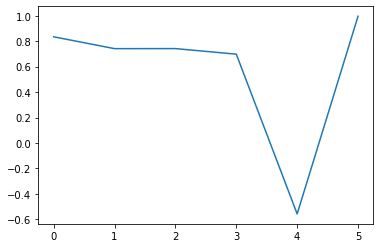

(6,)


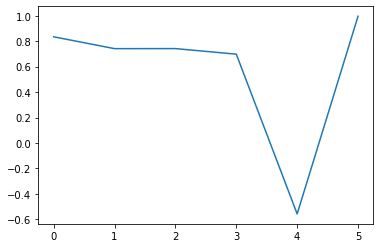

(6,)


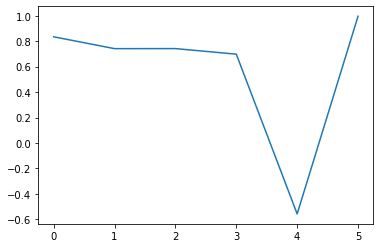

(6,)


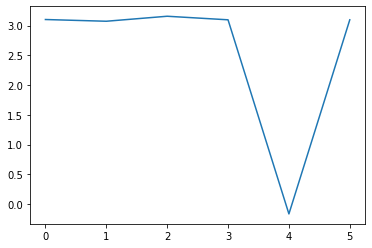

(6,)


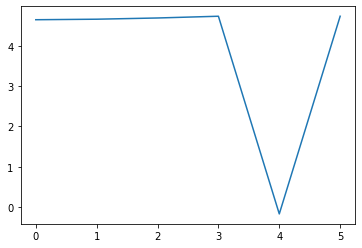

(6,)


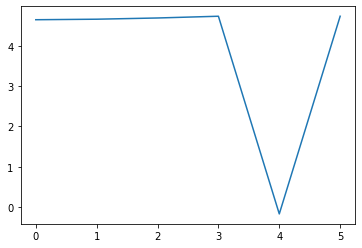

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch
import matplotlib.pyplot as plt 
import numpy as np
import matplotlib
# data_pred = np.load('./results/ETTh1_96_24_Autoformer_ETTh1_ftM_sl96_ll48_pl24_dm512_nh8_el2_dl1_df2048_fc1_ebtimeF_dtTrue_Exp_0/pred.npy')
data_pred = np.load('./results/gold_14_1_Autoformer_custom_ftM_sl14_ll0_pl1_dm512_nh8_el2_dl1_df2048_fc1_ebtimeF_dtTrue_Exp_0/real_prediction.npy')
#data_pred = torch.from_numpy(data_pred).permute(0,2,1)
plt.figure()
print(data_pred.shape)
#预测OT
plt.plot(data_pred[-1,-1,:])#由于prediction.shape是[1,24,7]那么batch只有1 索引只能是0或-1 都是代表batch这一维本身,如果是加载np文件就不一样了
print(data_pred[-1,-1,:].shape)
plt.show()
plt.plot(data_pred[0,-1,:])#没问题
print(data_pred[0,-1,:].shape)
plt.show()
# draw HUFL prediction
plt.plot(data_pred[0,0,:])#没问题
print(data_pred[-1,-1,:].shape)
plt.show()
'''
Ground Truth
'''
data_gt = np.load('./results/gold_14_1_Autoformer_custom_ftM_sl14_ll0_pl1_dm512_nh8_el2_dl1_df2048_fc1_ebtimeF_dtTrue_Exp_0/true.npy')
#data_gt = torch.from_numpy(data_gt).permute(0,2,1)

#预测OT
plt.plot(data_gt[-1,-1,:])#由于prediction.shape是[1,24,7]那么batch只有1 索引只能是0或-1 都是代表batch这一维本身,如果是加载np文件就不一样了
print(data_gt[-1,-1,:].shape)
plt.show()
plt.plot(data_gt[0,-1,:])#没问题
print(data_gt[0,-1,:].shape)
plt.show()
# draw HUFL prediction
plt.plot(data_gt[0,0,:])#没问题
print(data_gt[-1,-1,:].shape)
plt.show()



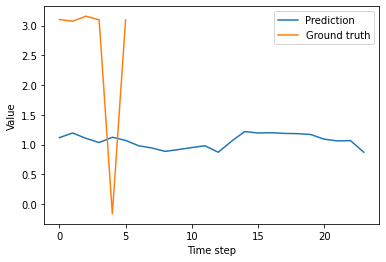

In [14]:
import matplotlib.pyplot as plt

# Collect data
prediction_data = np.load('./results/gold_36_24_Autoformer_custom_ftM_sl96_ll48_pl24_dm512_nh8_el2_dl1_df2048_fc1_ebtimeF_dtTrue_Exp_0/real_prediction.npy')
prediction_data = torch.from_numpy(prediction_data).permute(0,2,1)
ground_truth_data = np.load('./results/gold_14_1_Autoformer_custom_ftM_sl14_ll0_pl1_dm512_nh8_el2_dl1_df2048_fc1_ebtimeF_dtTrue_Exp_0/true.npy')
#ground_truth_data = torch.from_numpy(ground_truth_data).permute(0,2,1)

# Create figure and set up axes
fig, ax = plt.subplots()

# Plot prediction data
ax.plot(prediction_data[-1,-1,:], label='Prediction')

# Plot ground truth data
ax.plot(ground_truth_data[-1,-1,:], label='Ground truth')

# Add legend and labels
ax.legend()
ax.set_xlabel('Time step')
ax.set_ylabel('Value')

# Show plot
plt.show()